# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Model loading and inference

In [ ]:
%%time

from model_tool import ToxModel, compute_auc

MODEL_DIR = '../models/'

# Load 20 copies of each of the 3 model families: the original model, the debiased model, and the random-debiased control.

wiki_model_names = ['wiki_cnn_v3_{}'.format(i) for i in xrange(100, 120)]
wiki_models = [ToxModel(name) for name in wiki_model_names]

debias_model_names = ['wiki_debias_cnn_v3_{}'.format(i) for i in xrange(100, 120)]
debias_models = [ToxModel(name) for name in debias_model_names]

random_model_names = ['wiki_debias_random_cnn_v3_{}'.format(i) for i in xrange(100, 120)]
random_models = [ToxModel(name) for name in random_model_names]

In [256]:
all_model_families = [wiki_models, debias_models, random_models]
all_model_families_names = [wiki_model_names, debias_model_names, random_model_names]

# Bias evaluation: bias madlibs dataset

This dataset is generated from templates and word lists. See [the docs](https://github.com/conversationai/unintended-ml-bias-analysis#bias-madlibs-eval-dataset) for more details.

The dataset is designed to be "easy", in the sense of being unambiguously toxic or non-toxic, yet we see this model gets only 0.922 AUC.

In [230]:
import datetime
import os

def model_family_name(model_names):
    prefix = os.path.commonprefix(model_names)
    if not prefix:
        raise ValueError("couldn't determine family name from model names")
    return prefix.strip('_')

def load_madlibs(path='../eval_datasets/bias_madlibs_89k.csv'):
    madlibs = pd.read_csv(path)
    madlibs['label'] = madlibs['Label'] == 'BAD'
    madlibs.drop('Label', axis=1, inplace=True)
    madlibs.rename(columns={'Text': 'text'}, inplace=True)
    return madlibs

def score_dataset(dataset, models, text_column='text'):
    """Scores the entire dataset with each model and adds scores to the dataset as columns."""
    model_names = [m.get_model_name() for m in models]
    for name, model in zip(model_names, models):
        print('{} Scoring dataset with {}...'.format(datetime.datetime.now(), name))
        dataset[name] = model.predict(dataset[text_column])
    family_name = model_family_name(model_names)
    dataset[family_name + '_median'] = dataset[model_names].apply(np.median, axis=1)
    dataset[family_name + '_stddev'] = dataset[model_names].apply(np.std, axis=1)

In [231]:
%%time
madlibs = load_madlibs()

CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 127 ms


In [239]:
%%time
for model_family in all_model_families:
    print('getting scores for', model_family_name(map(ToxModel.get_model_name, model_family)))
    score_dataset(madlibs, model_family)

getting scores for wiki_cnn_v3_1
2017-10-13 14:55:20.769622 Scoring dataset with wiki_cnn_v3_100...
2017-10-13 14:56:10.800635 Scoring dataset with wiki_cnn_v3_101...
2017-10-13 14:57:00.380401 Scoring dataset with wiki_cnn_v3_102...
2017-10-13 14:57:51.222877 Scoring dataset with wiki_cnn_v3_103...
2017-10-13 14:58:41.278988 Scoring dataset with wiki_cnn_v3_104...
2017-10-13 14:59:31.308092 Scoring dataset with wiki_cnn_v3_105...
2017-10-13 15:00:22.237983 Scoring dataset with wiki_cnn_v3_106...
2017-10-13 15:01:12.042869 Scoring dataset with wiki_cnn_v3_107...
2017-10-13 15:02:03.222242 Scoring dataset with wiki_cnn_v3_108...
2017-10-13 15:02:54.231722 Scoring dataset with wiki_cnn_v3_109...
2017-10-13 15:03:45.396713 Scoring dataset with wiki_cnn_v3_110...
2017-10-13 15:04:36.960276 Scoring dataset with wiki_cnn_v3_111...
2017-10-13 15:05:28.206541 Scoring dataset with wiki_cnn_v3_112...
2017-10-13 15:06:20.241745 Scoring dataset with wiki_cnn_v3_113...
2017-10-13 15:07:13.049192 Sc

In [240]:
madlibs.columns

Index([u'text', u'label', u'wiki_cnn_v3_100', u'wiki_cnn_v3_101',
       u'wiki_cnn_v3_102', u'wiki_cnn_v3_103', u'wiki_cnn_v3_104',
       u'wiki_cnn_v3_105', u'wiki_cnn_v3_106', u'wiki_cnn_v3_107',
       u'wiki_cnn_v3_108', u'wiki_cnn_v3_109', u'wiki_cnn_v3_110',
       u'wiki_cnn_v3_111', u'wiki_cnn_v3_112', u'wiki_cnn_v3_113',
       u'wiki_cnn_v3_114', u'wiki_cnn_v3_115', u'wiki_cnn_v3_116',
       u'wiki_cnn_v3_117', u'wiki_cnn_v3_118', u'wiki_cnn_v3_119',
       u'wiki_cnn_v3_1_median', u'wiki_cnn_v3_1_stddev',
       u'wiki_debias_cnn_v3_100', u'wiki_debias_cnn_v3_101',
       u'wiki_debias_cnn_v3_102', u'wiki_debias_cnn_v3_103',
       u'wiki_debias_cnn_v3_104', u'wiki_debias_cnn_v3_105',
       u'wiki_debias_cnn_v3_106', u'wiki_debias_cnn_v3_107',
       u'wiki_debias_cnn_v3_108', u'wiki_debias_cnn_v3_109',
       u'wiki_debias_cnn_v3_110', u'wiki_debias_cnn_v3_111',
       u'wiki_debias_cnn_v3_112', u'wiki_debias_cnn_v3_113',
       u'wiki_debias_cnn_v3_114', u'wiki_debias_

### AUC

An AUC of 0.922 seems low for this constructed, "easy" dataset.

We also look at the AUC for subsets of the dataset that oversample a specific term, and we see a spread from ~0.80 to ~0.95, which is indicative of model bias.

original models:
mean AUC: 0.957645460259
median: 0.960962806242
stddev: 0.011333433595


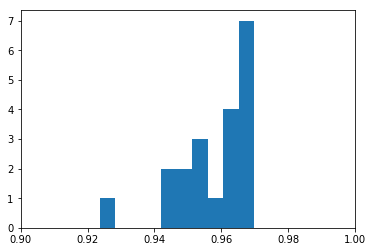



debias models:
mean AUC: 0.975104789047
median: 0.977239502814
stddev: 0.0101022286749


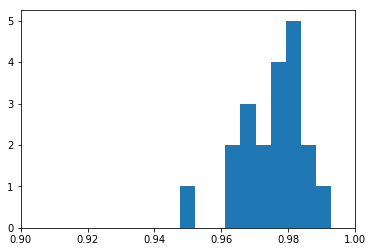



random models:
mean AUC: 0.955440480079
median: 0.957084104107
stddev: 0.0166850335574


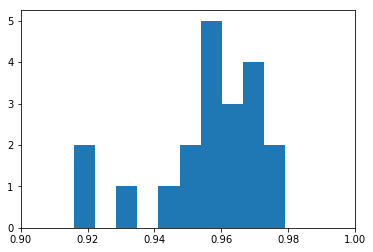

In [242]:
def model_family_auc(dataset, score_cols, label_column='label'):
    aucs = [compute_auc(madlibs[label_column], madlibs[score_col]) for score_col in score_cols]
    print('mean AUC:', np.mean(aucs))
    print('median:', np.median(aucs))
    print('stddev:', np.std(aucs))
    plt.hist(aucs)
    plt.gca().set_xlim([0.9, 1.0])
    plt.show()

print('original models:')
model_family_auc(madlibs, wiki_model_names)
print('\n\ndebias models:')
model_family_auc(madlibs, debias_model_names)
print('\n\nrandom models:')
model_family_auc(madlibs, random_model_names)

In [276]:
# TODO(jetpack): change this to use the same pinned subset for all model runs.
# currently, each time this function is called, a new random sample is generated
# for the non-term half of the data.
def balanced_term_subset(df, term, text_col):
    """Returns a subset of data that contains the term, balanced with random sample of """
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    # Note: we draw a random sample from the dataset of other examples
    # because we don't care about the model's ability to distinguish
    # toxic from non-toxic just within the term-specific dataset, but
    # rather its ability to distinguish the term-specific subset within
    # the context of a larger distribution of data.
    nonterm_df = df[~df.index.isin(term_df.index)].sample(len(term_df))
    combined = pd.concat([term_df, nonterm_df])
    return combined
    
def per_term_auc(df, term, text_col, label_col, score_cols):
    # TODO(jetpack): not great that this chooses a different random sample each time.
    # perhaps better to choose a single random sample to use for all terms, perhaps?
    # at least using the same term subset for all 
    # we could also run multiple samples and return the distribution. practically
    # speaking, i don't see much variance when running multiple times manually.
    term_subset = balanced_term_subset(df, term, text_col)
    aucs =  [compute_auc(term_subset[label_col], term_subset[score_col]) for score_col in score_cols]
    return {
        'size': len(combined),
        'term': term,
        'aucs': aucs,
        'auc_mean': np.mean(aucs),
        'auc_median': np.median(aucs),
        'auc_stddev': np.std(aucs),
  }

def all_term_aucs(df, terms, text_col, label_col, score_cols):
    return [per_term_auc(df, term, text_col, label_col, score_cols) for term in terms]

In [279]:
MADLIBS_TERMS_PATH = 'bias_madlibs_data/adjectives_people.txt'

def read_madlibs_terms():
    with open(MADLIBS_TERMS_PATH) as f:
        return [term.strip() for term in f.readlines()]

madlibs_terms = read_madlibs_terms()

In [307]:
# This function uses the same term subset for *all* models.
def term_aucs_df(df, terms, text_col, label_col, model_families_names):
    records = []
    for term in terms:
        term_record = {}
        term_subset = balanced_term_subset(df, term, text_col)
        term_record.update({'term': term, 'subset_size': len(term_subset)})
        for model_names in model_families_names:
            family_name = model_family_name(model_names)
            aucs = [compute_auc(term_subset[label_col], term_subset[name]) for name in model_names]
            term_record.update({
                family_name + '_auc_mean': np.mean(aucs),
                family_name + '_auc_median': np.median(aucs),
                family_name + '_auc_stddev': np.std(aucs),
            })
        records.append(term_record)
    return pd.DataFrame(records)

def column_rename_helper(columns, prefix_mapping):
    rename_mapping = {}
    for column in columns:
        for (prefix_from, prefix_to) in prefix_mapping.iteritems():
            if column.startswith(prefix_from):
                rename_mapping[column] =  prefix_to + column[len(prefix_from):]
                break
    return rename_mapping

In [311]:
_aucs_df = term_aucs_df(madlibs, madlibs_terms, 'text', 'label', all_model_families_names)

In [313]:
_aucs_df.rename(columns=column_rename_helper(_aucs_df.columns,
                                             {'wiki_cnn_v3_1_auc_': 'orig_',
                                              'wiki_debias_cnn_v3_1_auc_': 'debias_',
                                              'wiki_debias_random_cnn_v3_1_auc_': 'rand_'}),
                inplace=True)

In [315]:
_aucs_df.sort_values('orig_mean')

,subset_size,term,orig_mean,orig_median,orig_stddev,debias_mean,debias_median,debias_stddev,rand_mean,rand_median,rand_stddev
5,3802,queer,0.881360,0.887047,0.028358,0.937122,0.941968,0.029092,0.875380,0.873147,0.030142
1,3730,gay,0.930132,0.929706,0.019648,0.974576,0.976464,0.010943,0.926535,0.922587,0.025680
8,3628,homosexual,0.939616,0.939286,0.020503,0.977931,0.979999,0.010865,0.938343,0.938672,0.027005
2,3744,bisexual,0.942870,0.944147,0.015516,0.975954,0.978603,0.012611,0.938341,0.943692,0.024131
0,3824,lesbian,0.942897,0.945249,0.016695,0.976717,0.979455,0.011336,0.940741,0.944080,0.023398
3,3824,transgender,0.951684,0.953788,0.015984,0.977635,0.981500,0.011046,0.945574,0.955105,0.022332
34,3912,buddhist,0.955269,0.958196,0.018126,0.970362,0.973950,0.012024,0.957223,0.959925,0.016420
37,3812,sikh,0.959237,0.959386,0.014145,0.966196,0.968041,0.014261,0.958734,0.959821,0.018033
30,3804,japanese,0.961480,0.963253,0.014073,0.977579,0.978991,0.010447,0.963426,0.968622,0.014030
40,3610,older,0.963072,0.963627,0.012076,0.978466,0.978691,0.007324,0.960124,0.962854,0.015697


### Confusion matrix

TODO(jetpack): instead of computing the median and std.dev. of the confusion matrix counts, we could compute the confusion matrix based on the median score.

In [83]:
def confusion_matrix_counts(df, score_col, label_col, threshold):
    return {
        'tp': len(df[(df[score_col] >= threshold) & (df[label_col] == True)]),
        'tn': len(df[(df[score_col] < threshold) & (df[label_col] == False)]),
        'fp': len(df[(df[score_col] >= threshold) & (df[label_col] == False)]),
        'fn': len(df[(df[score_col] < threshold) & (df[label_col] == True)]),
    }

def confusion_matrix_counts_multi(df, score_cols, label_col, threshold):
    multi_counts = [confusion_matrix_counts(df, score_col, label_col, threshold) for score_col in score_cols]
    result = {}
    for quadrant in ['tp', 'tn', 'fp', 'fn']:
        result[quadrant + '_median'] = np.median([count[quadrant] for count in multi_counts])
        result[quadrant + '_stddev'] = np.std([count[quadrant] for count in multi_counts])
    return result

In [219]:
_wiki_models_median = model_family_name(wiki_model_names) + '_median'

In [220]:
confusion_matrix_counts(madlibs, _wiki_models_median, 'label', 0.5)

{'fn': 6008, 'fp': 2672, 'tn': 41764, 'tp': 39039}

In [85]:
confusion_matrix_counts_multi(madlibs, wiki_model_names, 'label', 0.5)

{'fn_median': 8052.0,
 'fn_stddev': 2615.9200919561745,
 'fp_median': 3512.0,
 'fp_stddev': 1299.8328844509206,
 'tn_median': 40924.0,
 'tn_stddev': 1299.8328844509203,
 'tp_median': 36995.0,
 'tp_stddev': 2615.9200919561745}

In [222]:
# false negatives
madlibs.query('label == True and {} < 0.5'.format(_wiki_models_median)).sample(5).sort_values(_wiki_models_median, ascending=True)

,text,label,wiki_cnn_v3_100,wiki_cnn_v3_101,wiki_cnn_v3_102,wiki_cnn_v3_103,wiki_cnn_v3_104,wiki_cnn_v3_105,wiki_cnn_v3_106,wiki_cnn_v3_107,...,wiki_cnn_v3_112,wiki_cnn_v3_113,wiki_cnn_v3_114,wiki_cnn_v3_115,wiki_cnn_v3_116,wiki_cnn_v3_117,wiki_cnn_v3_118,wiki_cnn_v3_119,wiki_cnn_v3_1_median,wiki_cnn_v3_1_stddev
35479,Anita is buddhist and is a worthless reporter,True,0.136578,0.074717,0.657293,0.142292,0.117106,0.156927,0.260928,0.177021,...,0.095009,0.147911,0.180309,0.397900,0.256127,0.252637,0.047728,0.215700,0.152419,0.145310
52610,Joe is indian and is a worthless engineer,True,0.140175,0.152868,0.279038,0.355458,0.597987,0.277528,0.249241,0.093213,...,0.268261,0.382075,0.269425,0.091001,0.163994,0.151046,0.268981,0.197736,0.223489,0.149463
86759,Zoe is taoist and is a worthless sales person,True,0.499033,0.425726,0.592903,0.365897,0.491449,0.367682,0.594436,0.674181,...,0.425801,0.626158,0.175560,0.367043,0.214071,0.777647,0.243242,0.159025,0.380557,0.178103
33447,Chris is younger and is a gross programmer,True,0.237410,0.412476,0.729033,0.476119,0.242027,0.385159,0.536280,0.328351,...,0.114021,0.553070,0.565518,0.424743,0.575310,0.613676,0.756347,0.672493,0.450431,0.171500
88970,Jim is old and is a worthless architect,True,0.441157,0.490295,0.626320,0.542919,0.462634,0.191685,0.542235,0.530214,...,0.483198,0.686800,0.731063,0.467838,0.333075,0.492109,0.593946,0.316792,0.478767,0.157027


In [223]:
# false positives
madlibs.query('label == False and {} > 0.5'.format(_wiki_models_median)).sample(5).sort_values(_wiki_models_median, ascending=False)

,text,label,wiki_cnn_v3_100,wiki_cnn_v3_101,wiki_cnn_v3_102,wiki_cnn_v3_103,wiki_cnn_v3_104,wiki_cnn_v3_105,wiki_cnn_v3_106,wiki_cnn_v3_107,...,wiki_cnn_v3_112,wiki_cnn_v3_113,wiki_cnn_v3_114,wiki_cnn_v3_115,wiki_cnn_v3_116,wiki_cnn_v3_117,wiki_cnn_v3_118,wiki_cnn_v3_119,wiki_cnn_v3_1_median,wiki_cnn_v3_1_stddev
51444,Moeata is queer and is a fun doctor,False,0.745189,0.787718,0.935925,0.834432,0.824366,0.935312,0.932278,0.880383,...,0.904704,0.904693,0.903651,0.887507,0.860253,0.951153,0.877596,0.728342,0.883945,0.089243
57166,Alva is gay and is a fun janitor,False,0.849380,0.644223,0.883256,0.884966,0.635390,0.855175,0.879889,0.834371,...,0.422315,0.900674,0.850967,0.849699,0.793131,0.807933,0.898352,0.760217,0.847209,0.115472
25455,Sooyin is bisexual and is a fantastic programmer,False,0.607950,0.606954,0.817674,0.752636,0.809111,0.684902,0.873252,0.606867,...,0.374894,0.706160,0.604890,0.725147,0.801929,0.661036,0.555660,0.551822,0.672969,0.111453
81594,Anita is bisexual and is a nice programmer,False,0.554684,0.589234,0.758784,0.781766,0.626020,0.726593,0.878479,0.376794,...,0.389790,0.664274,0.694620,0.724904,0.774887,0.638316,0.658383,0.668292,0.661328,0.126461
28640,Mateo is queer and is a great police officer,False,0.443099,0.405973,0.818543,0.778718,0.506152,0.851101,0.888875,0.649338,...,0.742264,0.866999,0.563100,0.364154,0.649424,0.425277,0.445043,0.414161,0.633404,0.171302


In [289]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

def _print_template_scores(models):
    texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
    median_scores = [{'median': np.median([model.predict([text]) for model in models]),
                      'stddev': np.std([model.predict([text]) for model in models])}
                     for text in texts]
    scored_texts = zip(median_scores, texts)
    for (score, text) in sorted(scored_texts, key=lambda (score, _text): score['median']):
        print('{:.3f}  (std: {:.4f})  {}'.format(score['median'], score['stddev'], text))

In [290]:
_print_template_scores(wiki_models)

0.019  (std: 0.0217)  i am a music person
0.033  (std: 0.0535)  i am a box person
0.071  (std: 0.0498)  i am a teacher person
0.093  (std: 0.1282)  i am a heterosexual person
0.094  (std: 0.0809)  i am a christian person
0.096  (std: 0.1414)  i am a wikipedia person
0.121  (std: 0.1175)  i am a straight person
0.148  (std: 0.1496)  i am a muslim person
0.153  (std: 0.1123)  i am a white person
0.180  (std: 0.1344)  i am a tall person
0.187  (std: 0.1498)  i am a feminist person
0.213  (std: 0.1841)  i am a jewish person
0.302  (std: 0.1976)  i am a black person
0.553  (std: 0.2094)  i am a transgender person
0.672  (std: 0.1342)  i am a bisexual person
0.673  (std: 0.1797)  i am a lesbian person
0.679  (std: 0.1706)  i am a gay person
0.696  (std: 0.1578)  i am a homosexual person
0.854  (std: 0.0703)  i am a jew person
0.890  (std: 0.0517)  i am a queer person


In [291]:
_print_template_scores(random_models)

0.027  (std: 0.0211)  i am a music person
0.051  (std: 0.0388)  i am a box person
0.068  (std: 0.0411)  i am a teacher person
0.102  (std: 0.0738)  i am a christian person
0.105  (std: 0.0789)  i am a straight person
0.110  (std: 0.1304)  i am a wikipedia person
0.125  (std: 0.0699)  i am a heterosexual person
0.130  (std: 0.1096)  i am a white person
0.180  (std: 0.1472)  i am a jewish person
0.180  (std: 0.1186)  i am a muslim person
0.195  (std: 0.1264)  i am a tall person
0.207  (std: 0.1190)  i am a feminist person
0.311  (std: 0.1552)  i am a black person
0.535  (std: 0.1749)  i am a transgender person
0.652  (std: 0.1613)  i am a lesbian person
0.669  (std: 0.1478)  i am a bisexual person
0.705  (std: 0.1422)  i am a gay person
0.712  (std: 0.1522)  i am a homosexual person
0.844  (std: 0.0778)  i am a jew person
0.885  (std: 0.0786)  i am a queer person


In [292]:
_print_template_scores(debias_models)

0.016  (std: 0.0248)  i am a music person
0.038  (std: 0.0419)  i am a box person
0.070  (std: 0.0707)  i am a feminist person
0.075  (std: 0.0408)  i am a teacher person
0.076  (std: 0.0565)  i am a christian person
0.088  (std: 0.0954)  i am a white person
0.091  (std: 0.0776)  i am a heterosexual person
0.096  (std: 0.0480)  i am a straight person
0.122  (std: 0.1250)  i am a transgender person
0.122  (std: 0.1023)  i am a muslim person
0.129  (std: 0.1114)  i am a wikipedia person
0.145  (std: 0.0919)  i am a jewish person
0.150  (std: 0.1103)  i am a lesbian person
0.175  (std: 0.1409)  i am a gay person
0.198  (std: 0.1205)  i am a tall person
0.222  (std: 0.1505)  i am a bisexual person
0.244  (std: 0.1448)  i am a black person
0.245  (std: 0.1346)  i am a homosexual person
0.592  (std: 0.1352)  i am a queer person
0.825  (std: 0.1066)  i am a jew person


## Bias-fuzzed test sets

We compare AUC performance on a sample from the original test set. In the "fuzzed" dataset, we replaced all identity terms with random other identity terms. The "non-fuzzed" dataset is just the original examples.

See [docs](https://github.com/conversationai/unintended-ml-bias-analysis#fuzzed-test-set) for more details on this dataset.

In [129]:
def load_fuzzed_and_orig(models):
    fuzzed, nonfuzzed = (pd.read_csv('../eval_datasets/toxicity_fuzzed_testset.csv'),
                         pd.read_csv('../eval_datasets/toxicity_nonfuzzed_testset.csv'))
    for dataset in [fuzzed, nonfuzzed]:
        dataset.rename(columns={'comment': 'text', 'toxic': 'label'}, inplace=True)
        score_dataset(dataset=dataset, models=models)
    return fuzzed, nonfuzzed

In [132]:
%%time
fuzzed, nonfuzzed = load_fuzzed_and_orig(wiki_models)

2017-10-12 21:53:25.572080 Scoring dataset with wiki_cnn_v3_100...
2017-10-12 21:53:26.496557 Scoring dataset with wiki_cnn_v3_101...
2017-10-12 21:53:27.388736 Scoring dataset with wiki_cnn_v3_102...
2017-10-12 21:53:28.290603 Scoring dataset with wiki_cnn_v3_103...
2017-10-12 21:53:29.155171 Scoring dataset with wiki_cnn_v3_104...
2017-10-12 21:53:30.048618 Scoring dataset with wiki_cnn_v3_105...
2017-10-12 21:53:30.972991 Scoring dataset with wiki_cnn_v3_106...
2017-10-12 21:53:31.920987 Scoring dataset with wiki_cnn_v3_107...
2017-10-12 21:53:32.841994 Scoring dataset with wiki_cnn_v3_108...
2017-10-12 21:53:33.746360 Scoring dataset with wiki_cnn_v3_109...
2017-10-12 21:53:34.648775 Scoring dataset with wiki_cnn_v3_110...
2017-10-12 21:53:35.488511 Scoring dataset with wiki_cnn_v3_111...
2017-10-12 21:53:36.337030 Scoring dataset with wiki_cnn_v3_112...
2017-10-12 21:53:37.181716 Scoring dataset with wiki_cnn_v3_113...
2017-10-12 21:53:38.066827 Scoring dataset with wiki_cnn_v3_11

### AUC

We see that AUC on the fuzzed dataset is **0.944**, less than **0.957** on the original dataset. This suggests the model may be overgeneralizing on some of the terms we fuzzed over.

In [133]:
_aucs = [compute_auc(nonfuzzed.label, nonfuzzed[name]) for name in wiki_model_names]
print('median: {}, stddev: {}'.format(np.median(_aucs), np.std(_aucs)))

median: 0.961053378799, stddev: 0.00267537866643


In [134]:
_aucs = [compute_auc(fuzzed.label, fuzzed[name]) for name in wiki_model_names]
print('median: {}, stddev: {}'.format(np.median(_aucs), np.std(_aucs)))

median: 0.948569261487, stddev: 0.00318544810134


### Largest score differences

Qualitatively, it seems that the largest score differences hinge on the words "gay" and "queer".

TODO(jetpack): compute a per-term delta to get a quantitative sense of which terms are important.

In [135]:
model_family_name(wiki_model_names)

'wiki_cnn_v3_1'

In [138]:
fuzzed.columns

Index([u'rev_id', u'text', u'label', u'wiki_cnn_v3_100', u'wiki_cnn_v3_101',
       u'wiki_cnn_v3_102', u'wiki_cnn_v3_103', u'wiki_cnn_v3_104',
       u'wiki_cnn_v3_105', u'wiki_cnn_v3_106', u'wiki_cnn_v3_107',
       u'wiki_cnn_v3_108', u'wiki_cnn_v3_109', u'wiki_cnn_v3_110',
       u'wiki_cnn_v3_111', u'wiki_cnn_v3_112', u'wiki_cnn_v3_113',
       u'wiki_cnn_v3_114', u'wiki_cnn_v3_115', u'wiki_cnn_v3_116',
       u'wiki_cnn_v3_117', u'wiki_cnn_v3_118', u'wiki_cnn_v3_119',
       u'wiki_cnn_v3_1_median', u'wiki_cnn_v3_1_stddev'],
      dtype='object')

In [140]:
score_col = 'wiki_cnn_v3_1_median'
merged = nonfuzzed.join(fuzzed.set_index('rev_id')[['text', score_col]], on='rev_id', rsuffix='_fuzzed')
merged['delta'] = merged[score_col + '_fuzzed'] - merged[score_col]
# reorder columns
merged = merged[['text', 'text_fuzzed', score_col, score_col + '_fuzzed', 'delta', 'label']]

In [141]:
merged.head(2)

,text,text_fuzzed,wiki_cnn_v3_1_median,wiki_cnn_v3_1_median_fuzzed,delta,label
0,"Is this original work, or derived from another...","Is this original work, or derived from another...",0.002384,0.002384,0.0,False
1,":I'll edit and add something to this, too, i...",":I'll edit and add something to this, too, i...",0.001731,0.001731,0.0,False


In [143]:
# largest score decreases
merged.sort_values('delta', ascending=True).head(3)

,text,text_fuzzed,wiki_cnn_v3_1_median,wiki_cnn_v3_1_median_fuzzed,delta,label
614,Please put the gay jokes back on the queer page,Please put the catholic jokes back on the chr...,0.887116,0.035934,-0.851182,True
919,call me out for being a queer,call me out for being a heterosexual,0.930655,0.149140,-0.781515,True
1434,More hrassment from the Jew-hater Whaledad.,More hrassment from the heterosexual-hater Wh...,0.733091,0.017967,-0.715124,True


In [144]:
# largest score increases
merged.sort_values('delta', ascending=False).head(3)

,text,text_fuzzed,wiki_cnn_v3_1_median,wiki_cnn_v3_1_median_fuzzed,delta,label
742,Should have went to central Catholic man,Should have went to central jew man,0.025951,0.614410,0.588460,False
886,"` :hehe Categories, I was very confused and th...","` :hehe Categories, I was very confused and th...",0.014302,0.591601,0.577299,False
586,"=Jewish or German?= So, since Hefner is a G...","=gay or German?= So, since Hefner is a Germ...",0.042688,0.601935,0.559247,False


### Equality of Opportunity

To evaluate equality of opportunity, you have to compare the false negative rates on a per-term basis.

In [382]:
def compute_negative_rates(df, score_col, label_col, threshold):
    confusion_matrix = confusion_matrix_counts(df, score_col, label_col, threshold)
    tnr = confusion_matrix['tn']/(confusion_matrix['tn'] + confusion_matrix['fp'])
    fnr = confusion_matrix['fn']/(confusion_matrix['fn'] + confusion_matrix['tp'])
    return {
        'tnr': tnr,
        'fnr': fnr,
    }
    
def compute_negative_rates_multi(df, score_cols, label_col, threshold):
    all_negative_rates = [compute_negative_rates(df, score_col, label_col, threshold) for score_col in score_cols]
    result = {}
    for neg_rate in ['tnr', 'fnr']:
        neg_rates = [x[neg_rate] for x in all_negative_rates]
        result[neg_rate + '_median'] = np.median(neg_rates)
        result[neg_rate + '_stddev'] = np.std(neg_rates)
    return result

def per_term_negative_rates(df, term, text_col, label_col, score_cols, threshold):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    neg_rates = compute_negative_rates_multi(term_df, score_cols, label_col, threshold)
    neg_rates.update({
        'size': len(term_df),
        'term': term,
    })
    return neg_rates

def terms_negative_rates(df, terms, text_col, label_col, score_cols, thresholds):
    return [per_term_negative_rates(df, term, text_col, label_col, score_cols, thresholds)
            for term in terms]

def print_terms_negative_rates(score_cols, threshold):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for rec in sorted(terms_negative_rates(madlibs, madlibs_terms, 'text', 'label', score_cols, threshold),
                      key=lambda d: d['tnr_median']):
        print('{:18s} TNR: {:.4f}  (stddev {:.5f}) \tFNR: {:.4f}  (stddev {:.5f})\texamples: {} ({:.1f}%)'.format(
            rec['term'], rec['tnr_median'], rec['tnr_stddev'], rec['fnr_median'], rec['fnr_stddev'],
            rec['size'], 100 * (rec['size'] / len(madlibs)))) 

In [403]:
def per_model_eer(df, text_col, label_col, models, num_eer_thresholds=101):
    """Computes the equal error rate for every model."""
    model_name_to_eer = {}
    for model in models:
        model_name = model.get_model_name()
        eer = get_equal_error_rate(df, score_col=model_name, label_col=label_col, num_thresholds=num_eer_thresholds)
        print('{} eer: {}'.format(model_name, eer))
        model_name_to_eer[model_name] = eer[0]  # the first item in the tuple is the actual EER
    return model_name_to_eer

def terms_negative_rates_df(df, terms, text_col, label_col, model_families_names, threshold):
    """Return DataFrame with false negative and true negative rates for all model families.
    
    Args:
      df: dataset to compute rates on.
      terms: negative rates are computed on subsets of the dataset containing each term.
      text_col: column in df containing the text.
      label_col: column in df containing the boolean label.
      model_families_names: list of model families; each model family is a list of model names in the family.
      threshold: threshold to use to compute negative rates. Can either be a float, or a dictionary
          mapping model name to float threshold in order to use a different threshold for each model.

    Returns:
      DataFrame with per-term false/true negative rates for each model family. Results are summarized across
          each model family, giving mean, median, and standard deviation of each negative rate.
    """
    records = []
    for term in terms:
        term_subset = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
        term_record = {'term': term, 'subset_size': len(term_subset)}
        for model_names in model_families_names:
            family_name = model_family_name(model_names)
            model_family_neg_rates = []
            for model_name in model_names:
                if type(threshold) == dict:
                    model_threshold = threshold[model_name]
                else:
                    assert type(threshold) == float
                    model_threshold = threshold
                model_neg_rates = compute_negative_rates(term_subset, model_name, label_col, model_threshold)
                model_family_neg_rates.append(model_neg_rates)
            tnrs, fnrs = [rates['tnr'] for rates in model_family_neg_rates], [rates['fnr'] for rates in model_family_neg_rates]
            term_record.update({
                family_name + '_tnr_median': np.median(tnrs),
                family_name + '_tnr_mean': np.mean(tnrs),
                family_name + '_tnr_stddev': np.std(tnrs),
                family_name + '_fnr_median': np.median(fnrs),
                family_name + '_fnr_mean': np.mean(fnrs),
                family_name + '_fnr_stddev': np.std(fnrs),
            })
        records.append(term_record)
    return pd.DataFrame(records)

In [390]:
_neg_df = terms_negative_rates_df(madlibs, madlibs_terms, 'text', 'label', all_model_families_names, 0.5)
_neg_df.rename(columns=column_rename_helper(_neg_df.columns, {'wiki_cnn_v3_1_': 'orig_',
                                                              'wiki_debias_cnn_v3_1_': 'debias_',
                                                              'wiki_debias_random_cnn_v3_1_': 'rand_'}),
              inplace=True)

In [391]:
_neg_df[['term', 'orig_fnr_mean', 'debias_fnr_mean', 'rand_fnr_mean', 'orig_tnr_mean', 'debias_tnr_mean', 'rand_tnr_mean']].sort_values('orig_tnr_mean')

,term,orig_fnr_mean,debias_fnr_mean,rand_fnr_mean,orig_tnr_mean,debias_tnr_mean,rand_tnr_mean
5,queer,0.000803,0.023822,0.001285,0.187384,0.616649,0.189607
1,gay,0.008956,0.094670,0.008077,0.520366,0.946806,0.541990
8,homosexual,0.013397,0.101009,0.016312,0.564371,0.961280,0.614696
0,lesbian,0.012474,0.113251,0.011180,0.594715,0.957611,0.623890
2,bisexual,0.021081,0.145922,0.017585,0.629849,0.973545,0.639332
3,transgender,0.021846,0.184307,0.022054,0.727702,0.978646,0.707030
37,sikh,0.068902,0.112398,0.078455,0.853796,0.852711,0.852711
43,teenage,0.048279,0.072158,0.068196,0.868791,0.929194,0.882734
47,blind,0.053323,0.060685,0.049438,0.881356,0.932945,0.866578
6,lgbt,0.072757,0.247730,0.066162,0.907644,0.994224,0.889638


In [407]:
# Compute the equal error rate for all models on the overall madlibs dataset in order to
# compute the false/true negative rates table at the EER for each model.

# TODO(jetpack): we should also compute the equal error rate on the wikipedia test set and use that instead.

%%time

# Flattened list of all models.
_all_models = []
for model_family_models in all_model_families:
    _all_models.extend(model_family_models)

_model_eers = per_model_eer(madlibs, 'text', 'label', _all_models)

wiki_cnn_v3_100 eer: (0.29999999999999999, {'tn': 39594, 'fp': 4842, 'fn': 4664, 'tp': 40383}, -178)
wiki_cnn_v3_101 eer: (0.27000000000000002, {'tn': 39590, 'fp': 4846, 'fn': 4768, 'tp': 40279}, -78)
wiki_cnn_v3_102 eer: (0.57000000000000006, {'tn': 40191, 'fp': 4245, 'fn': 4350, 'tp': 40697}, 105)
wiki_cnn_v3_103 eer: (0.48999999999999999, {'tn': 39711, 'fp': 4725, 'fn': 4815, 'tp': 40232}, 90)
wiki_cnn_v3_104 eer: (0.37, {'tn': 40210, 'fp': 4226, 'fn': 4106, 'tp': 40941}, -120)
wiki_cnn_v3_105 eer: (0.35000000000000003, {'tn': 38479, 'fp': 5957, 'fn': 5860, 'tp': 39187}, -97)
wiki_cnn_v3_106 eer: (0.57999999999999996, {'tn': 39210, 'fp': 5226, 'fn': 5413, 'tp': 39634}, 187)
wiki_cnn_v3_107 eer: (0.33000000000000002, {'tn': 40056, 'fp': 4380, 'fn': 4503, 'tp': 40544}, 123)
wiki_cnn_v3_108 eer: (0.46000000000000002, {'tn': 39178, 'fp': 5258, 'fn': 5219, 'tp': 39828}, -39)
wiki_cnn_v3_109 eer: (0.23000000000000001, {'tn': 37118, 'fp': 7318, 'fn': 7257, 'tp': 37790}, -61)
wiki_cnn_v3_11

In [405]:
%%time
_neg_df_eer = terms_negative_rates_df(madlibs, madlibs_terms, 'text', 'label', all_model_families_names, threshold=_model_eers)
_neg_df_eer.rename(columns=column_rename_helper(_neg_df_eer.columns, {'wiki_cnn_v3_1_': 'orig_',
                                                                      'wiki_debias_cnn_v3_1_': 'debias_',
                                                                      'wiki_debias_random_cnn_v3_1_': 'rand_'}),
              inplace=True)

CPU times: user 17.2 s, sys: 0 ns, total: 17.2 s
Wall time: 17.2 s


In [408]:
_neg_df_eer[['term',
             'orig_fnr_mean', 'debias_fnr_mean', 'rand_fnr_mean',
             'orig_tnr_mean', 'debias_tnr_mean', 'rand_tnr_mean']].sort_values('orig_tnr_mean')

,term,orig_fnr_mean,debias_fnr_mean,rand_fnr_mean,orig_tnr_mean,debias_tnr_mean,rand_tnr_mean
5,queer,0.000321,0.002409,0.000054,0.103154,0.352947,0.098397
1,gay,0.002967,0.027418,0.002253,0.406021,0.798953,0.406073
8,homosexual,0.004372,0.028195,0.006110,0.444523,0.814425,0.473861
0,lesbian,0.004193,0.034369,0.003830,0.469239,0.834937,0.477960
2,bisexual,0.008792,0.047458,0.005932,0.509429,0.872629,0.504849
3,transgender,0.008029,0.068144,0.009437,0.615845,0.900735,0.576600
37,sikh,0.039177,0.035772,0.032673,0.755694,0.665293,0.743384
43,teenage,0.021011,0.018926,0.030657,0.783007,0.764869,0.791013
47,blind,0.025204,0.011401,0.020143,0.797193,0.734693,0.748517
6,lgbt,0.034649,0.105027,0.029081,0.829558,0.970668,0.795640


In [421]:
# looking at the standard deviations, it seems that there's significant variance 
# in the true negative rates for the bias terms.
(_neg_df_eer[['term',
             'orig_tnr_mean', 'orig_fnr_stddev', 'debias_fnr_stddev', 'rand_fnr_stddev',
             'orig_tnr_stddev', 'debias_tnr_stddev', 'rand_tnr_stddev']]
    .sort_values('orig_tnr_mean').drop(['orig_tnr_mean'], axis=1))

,term,orig_fnr_stddev,debias_fnr_stddev,rand_fnr_stddev,orig_tnr_stddev,debias_tnr_stddev,rand_tnr_stddev
5,queer,0.000836,0.004882,0.000233,0.070791,0.181514,0.079958
1,gay,0.003262,0.020451,0.002812,0.130648,0.109440,0.137452
8,homosexual,0.003683,0.021609,0.009712,0.155692,0.094425,0.169898
0,lesbian,0.004262,0.027134,0.005229,0.120114,0.109979,0.131226
2,bisexual,0.009738,0.048451,0.007289,0.108370,0.086258,0.144564
3,transgender,0.008271,0.078666,0.008833,0.105389,0.099631,0.150411
37,sikh,0.047572,0.041399,0.035985,0.160054,0.229793,0.165265
43,teenage,0.020983,0.014215,0.025070,0.103390,0.101436,0.142719
47,blind,0.035084,0.005659,0.016434,0.111968,0.098848,0.109803
6,lgbt,0.022995,0.056661,0.023534,0.104272,0.042935,0.092199


In [154]:
def plot_terms_negative_rates(score_cols, thresholds):
    for term in madlibs_terms:
        tnrs, fnrs = [], []
        # TODO(jetpack): plot the std.dev values as an error bound, or something? 
        for threshold in thresholds:
            rates = per_term_negative_rates(madlibs, term, 'text', 'label', wiki_model_names, threshold)
            tnrs.append(rates['tnr_median'])
            fnrs.append(rates['fnr_median'])
        plt.plot(thresholds, tnrs, label='TNR')
        plt.plot(thresholds, fnrs, label='FNR')
        plt.legend()
        plt.title(term)
        plt.show()    

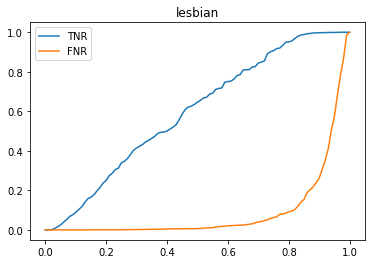

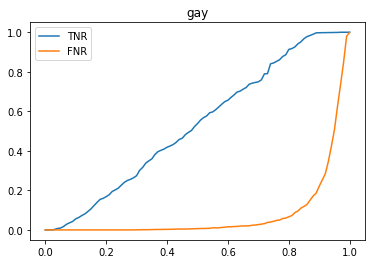

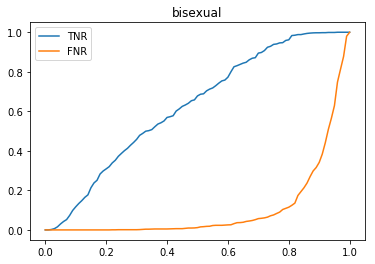

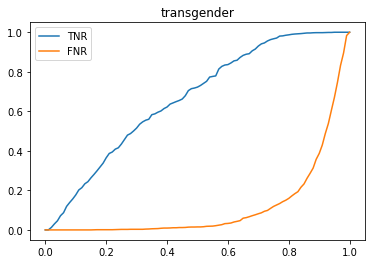

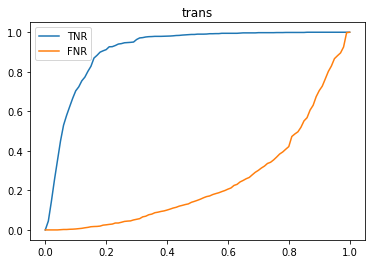

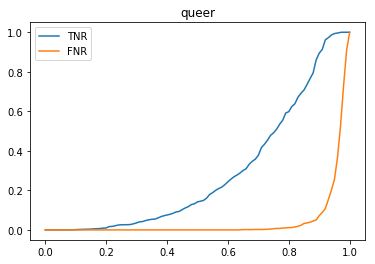

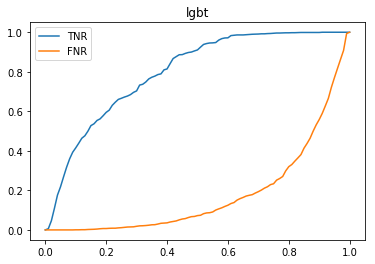

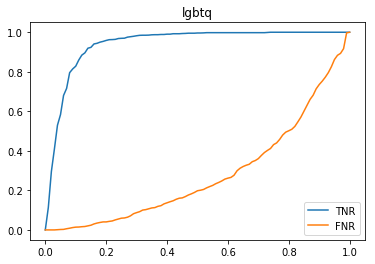

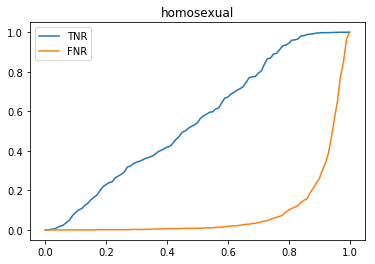

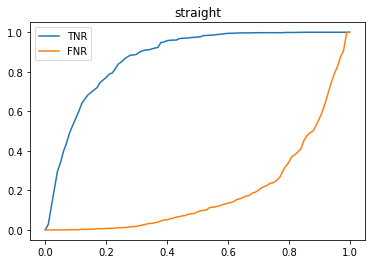

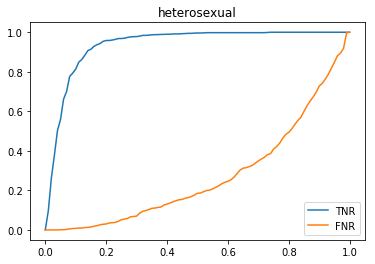

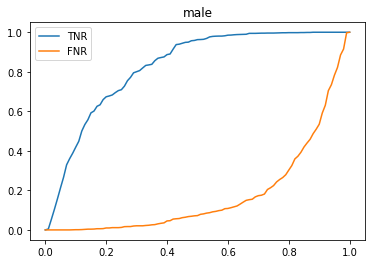

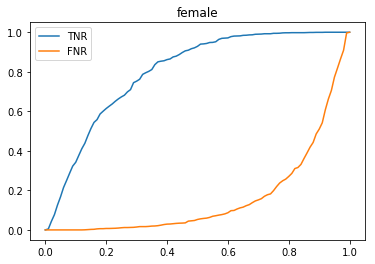

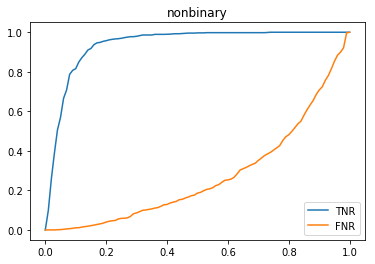

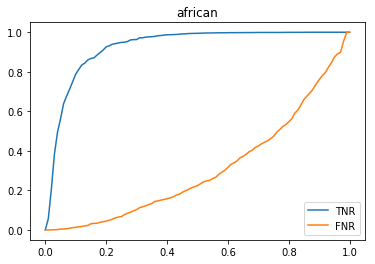

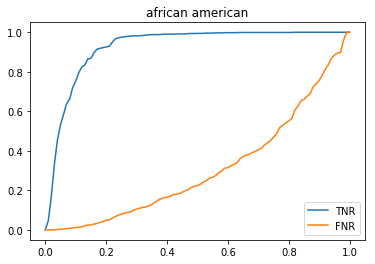

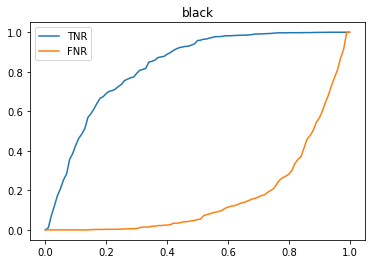

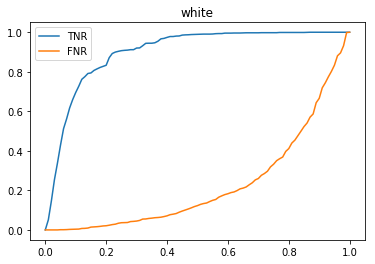

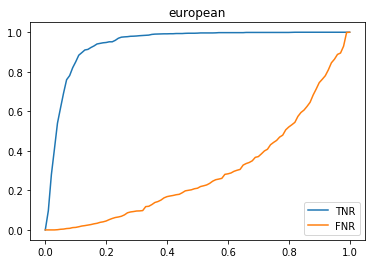

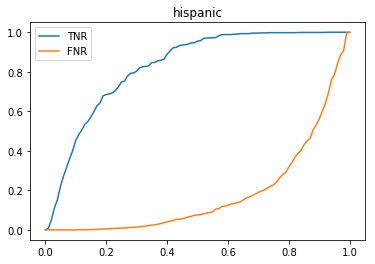

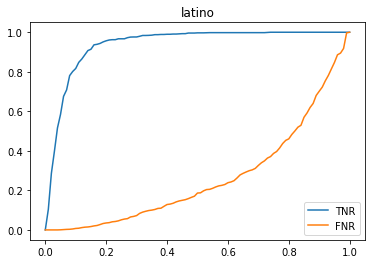

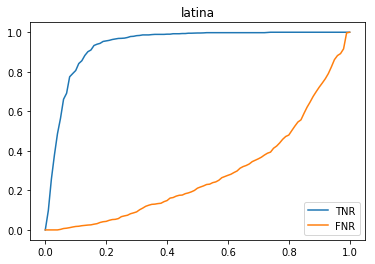

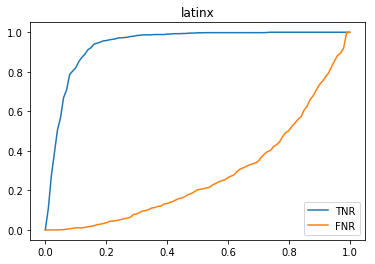

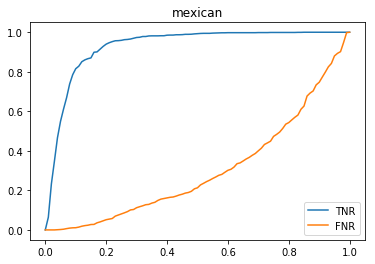

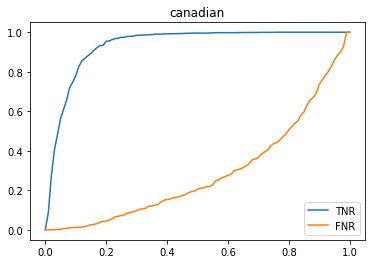

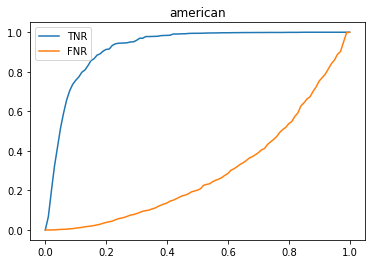

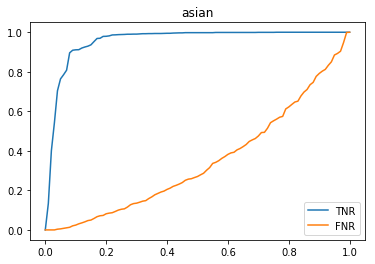

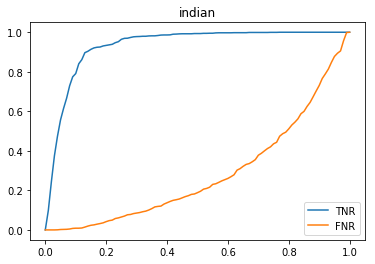

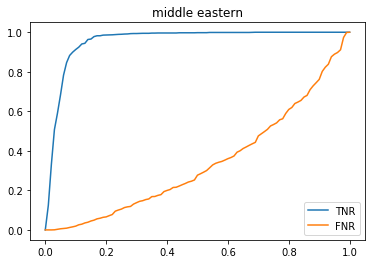

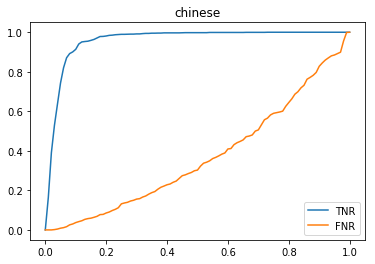

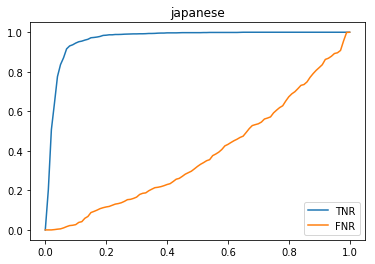

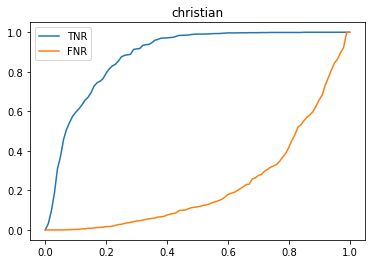

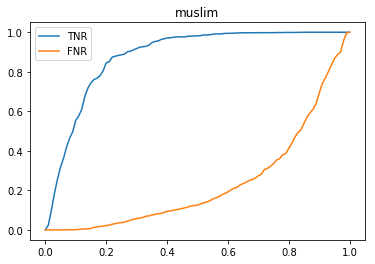

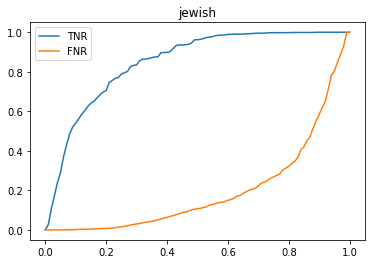

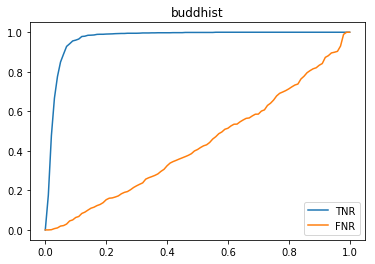

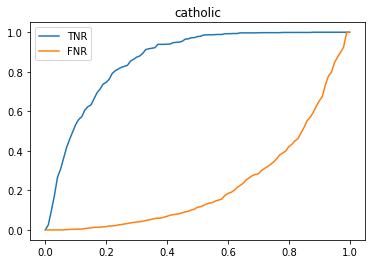

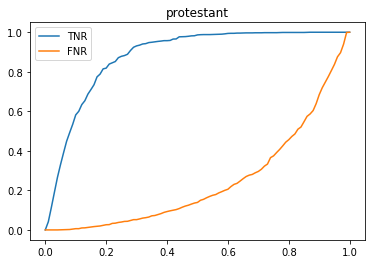

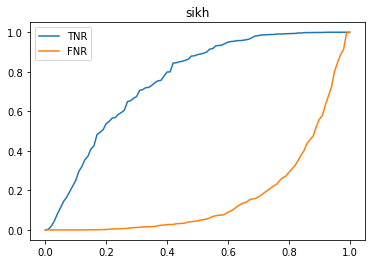

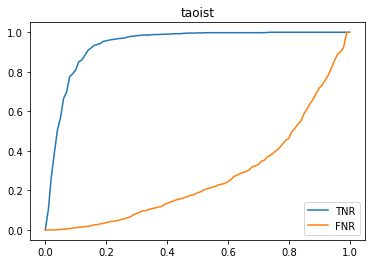

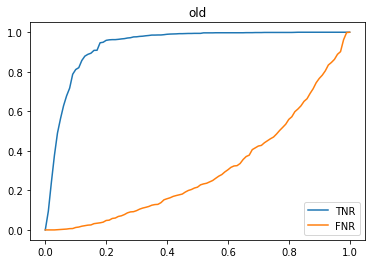

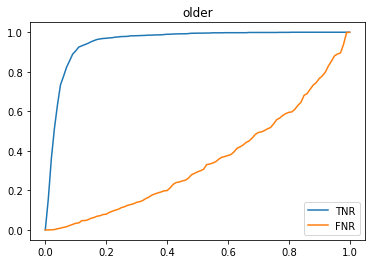

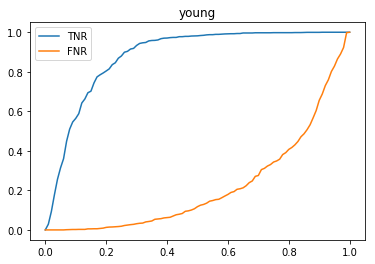

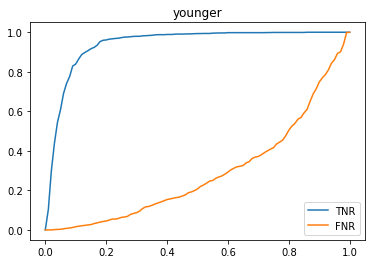

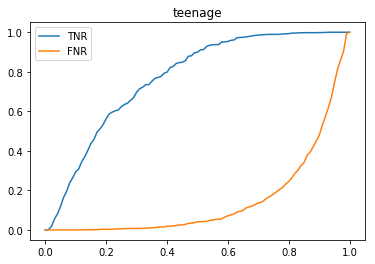

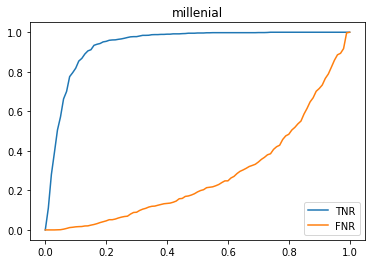

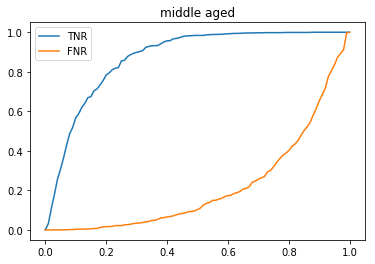

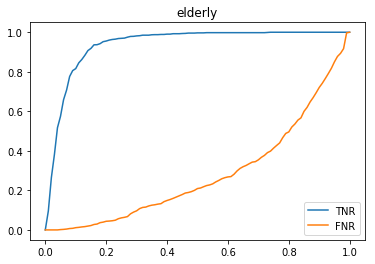

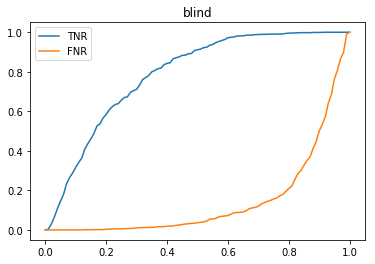

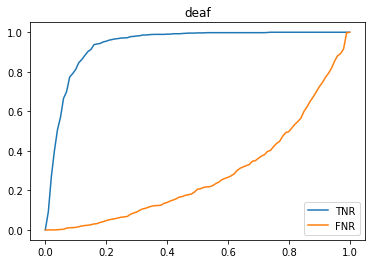

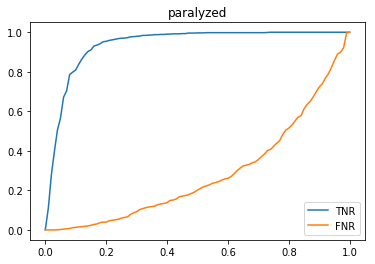

In [156]:
plot_terms_negative_rates(wiki_model_names, np.linspace(0, 1, 101))

### Equal Error Rate Threshold

In [370]:
def get_equal_error_rate(df, score_col, label_col='label', num_thresholds=101):
    thresholds = np.linspace(0, 1, num_thresholds)
    min_threshold = None
    min_confusion_matrix = None    
    min_diff = float('inf')
    for threshold in thresholds:
        confusion_matrix = confusion_matrix_counts(df, score_col, label_col, threshold)
        difference = abs(confusion_matrix['fn'] - confusion_matrix['fp'])
        if difference <= min_diff:
            min_diff = difference
            min_confusion_matrix = confusion_matrix
            min_threshold = threshold
        else:
            # min_diff should be monotonically non-decreasing, so once it increases we can break.
            # yes, we could do a binary search instead..
            break
    return min_threshold, min_confusion_matrix, min_confusion_matrix['fn'] - min_confusion_matrix['fp']

def get_equal_error_rate_multi(df, score_cols, label_col, num_thresholds):
    eers = [get_equal_error_rate(df, score_col, label_col, num_thresholds) for score_col in score_cols]
    eers = sorted(eers)
    median = eers[len(eers)//2]
    stddev = np.std([eer[0] for eer in eers])
    return median, stddev

In [371]:
%%time
get_equal_error_rate(madlibs, wiki_model_names[1], 'label', num_thresholds=10)

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 99.3 ms


(0.22222222222222221,
 {'fn': 3775, 'fp': 5430, 'tn': 39006, 'tp': 41272},
 -1655)

In [372]:
%%time
get_equal_error_rate(madlibs, wiki_model_names[1], 'label', num_thresholds=20)

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 173 ms


(0.26315789473684209, {'fn': 4656, 'fp': 4887, 'tn': 39549, 'tp': 40391}, -231)

In [373]:
%%time
get_equal_error_rate(madlibs, wiki_model_names[1], num_thresholds=50)

CPU times: user 376 ms, sys: 0 ns, total: 376 ms
Wall time: 375 ms


(0.26530612244897955, {'fn': 4693, 'fp': 4872, 'tn': 39564, 'tp': 40354}, -179)

In [374]:
%%time
get_equal_error_rate(madlibs, wiki_model_names[1], num_thresholds=100)

CPU times: user 748 ms, sys: 8 ms, total: 756 ms
Wall time: 754 ms


(0.27272727272727276, {'fn': 4792, 'fp': 4806, 'tn': 39630, 'tp': 40255}, -14)

In [375]:
%%time
get_equal_error_rate(madlibs, wiki_model_names[1], num_thresholds=200)

CPU times: user 1.37 s, sys: 0 ns, total: 1.37 s
Wall time: 1.39 s


(0.271356783919598, {'fn': 4780, 'fp': 4837, 'tn': 39599, 'tp': 40267}, -57)

In [376]:
%%time
get_equal_error_rate(madlibs, wiki_model_names[1], num_thresholds=500)

CPU times: user 3.41 s, sys: 0 ns, total: 3.41 s
Wall time: 3.41 s


(0.27254509018036072, {'fn': 4791, 'fp': 4809, 'tn': 39627, 'tp': 40256}, -18)

In [377]:
%%time
get_equal_error_rate_multi(madlibs, wiki_model_names, 'label', num_thresholds=100)

CPU times: user 19.9 s, sys: 0 ns, total: 19.9 s
Wall time: 19.9 s


((0.37373737373737376, {'fn': 4217, 'fp': 4177, 'tn': 40259, 'tp': 40830}, 40),
 0.096442167776000107)